In [1]:
# 필요한 라이브러리 설치
!pip install datasets torch torchvision scikit-learn matplotlib
!git clone https://github.com/HRNet/HRNet-Image-Classification
%cd HRNet-Image-Classification
!pip install -r requirements.txt
%cd ..

!wget -O /content/HRNet_W48_C_ssld_pretrained.pth https://github.com/HRNet/HRNet-Image-Classification/releases/download/PretrainedWeights/HRNet_W48_C_ssld_pretrained.pth
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from datasets import load_dataset
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.serialization import add_safe_globals


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# HRNet 모델 임포트
import sys
sys.path.append('HRNet-Image-Classification/lib')
from models.cls_hrnet import get_cls_net

# 데이터셋 로드
dataset = load_dataset("espada105/augmented-brain-tumor-segmentation-v2")
train = dataset["train"]
test = dataset["test"]
valid = dataset["valid"]

# 이미지 전처리 파이프라인 (강화된 증강)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(lambda x: x.convert('RGB') if x.mode != 'RGB' else x),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

README.md:   0%|          | 0.00/814 [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/408M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/407M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/404M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/407M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/234M [00:00<?, ?B/s]

valid-00000-of-00001.parquet:   0%|          | 0.00/462M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7510 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1075 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/2145 [00:00<?, ? examples/s]

In [3]:
# 커스텀 데이터셋 클래스
class BrainTumorDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]["image"]
        label = self.dataset[idx]["category_id"]  # 원본 유지 (1=Tumor, 2=Normal)
        if self.transform:
            image = self.transform(image)
        # 레이블을 [0,1] 범위로 조정하지 않고 원본 값 유지
        return image, torch.tensor(label, dtype=torch.float32)

# 데이터로더 생성
train_dataset = BrainTumorDataset(train, transform=transform)
valid_dataset = BrainTumorDataset(valid, transform=transform)
test_dataset = BrainTumorDataset(test, transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [4]:
# HRNet-W48-C-ssld 공식 모델 구성
hrnet_config = {
    'MODEL': {
        'NAME': 'cls_hrnet_w48',
        'EXTRA': {
            'STAGE1': {
                'NUM_MODULES': 1,
                'NUM_BRANCHES': 1,
                'BLOCK': 'BOTTLENECK',
                'NUM_BLOCKS': [4],
                'NUM_CHANNELS': [64],
                'FUSE_METHOD': 'SUM'
            },
            'STAGE2': {
                'NUM_MODULES': 1,
                'NUM_BRANCHES': 2,
                'BLOCK': 'BASIC',
                'NUM_BLOCKS': [4,4],
                'NUM_CHANNELS': [48, 96],
                'FUSE_METHOD': 'SUM'
            },
            'STAGE3': {
                'NUM_MODULES': 4,
                'NUM_BRANCHES': 3,
                'BLOCK': 'BASIC',
                'NUM_BLOCKS': [4,4,4],
                'NUM_CHANNELS': [48, 96, 192],
                'FUSE_METHOD': 'SUM'
            },
            'STAGE4': {
                'NUM_MODULES': 3,
                'NUM_BRANCHES': 4,
                'BLOCK': 'BASIC',
                'NUM_BLOCKS': [4,4,4,4],
                'NUM_CHANNELS': [48, 96, 192, 384],
                'FUSE_METHOD': 'SUM'
            }
        },
        'NUM_CLASSES': 1000
    }
}

# 모델 초기화 및 사전학습 가중치 로드
model = get_cls_net(hrnet_config)
pretrained_dict = torch.load('/content/HRNet_W48_C_ssld_pretrained.pth')
model.load_state_dict(pretrained_dict, strict=False)

# 안정적인 분류기 구조 (2-layer MLP)
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1)
)

In [5]:
# Focal Loss 정의 (클래스 불균형 대응)
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2.0, eps=1e-6):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        pt = torch.clamp(pt, self.eps, 1.0 - self.eps)  # NaN 방지
        loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return loss.mean()

# 학습 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = FocalLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Gradient Clipping 함수
def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)



Epoch 1/5
Train Loss: 0.0051 | Val F1: 0.9873 | Val Recall: 0.9962
Val Precision: 0.9785 | Val IoU: 0.9748 | Val AUC: 0.9996
New best model saved with AUC: 0.9996

Epoch 2/5
Train Loss: 0.0038 | Val F1: 0.9938 | Val Recall: 0.9895
Val Precision: 0.9981 | Val IoU: 0.9876 | Val AUC: 0.9998
New best model saved with AUC: 0.9998

Epoch 3/5
Train Loss: 0.0022 | Val F1: 0.9924 | Val Recall: 0.9952
Val Precision: 0.9896 | Val IoU: 0.9849 | Val AUC: 0.9998
New best model saved with AUC: 0.9998

Epoch 4/5
Train Loss: 0.0017 | Val F1: 0.9905 | Val Recall: 0.9971
Val Precision: 0.9840 | Val IoU: 0.9813 | Val AUC: 0.9997

Epoch 5/5
Train Loss: 0.0009 | Val F1: 0.9952 | Val Recall: 0.9905
Val Precision: 1.0000 | Val IoU: 0.9905 | Val AUC: 0.9998
안전 모드 로딩 실패: Weights only load failed. In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in 

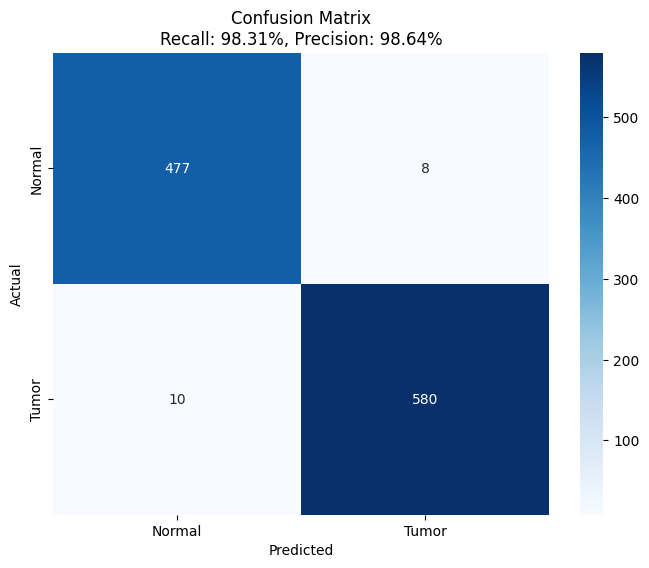

In [7]:
# 학습 루프
num_epochs = 5
best_val_auc = 0
grad_clip = 1.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)  # [batch_size, 1] 형태 유지

        # 레이블 변환: 2(Normal)→0, 1(Tumor)→1
        labels_binary = torch.where(labels == 1, 1.0, 0.0)

        # 출력 차원 조정: [batch_size, 1] → [batch_size]
        loss = criterion(outputs.squeeze(1), labels_binary)

        loss.backward()
        clip_gradient(optimizer, grad_clip)
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        total_samples += images.size(0)

    train_loss /= total_samples
    scheduler.step()

    # 검증 단계
    model.eval()
    val_probs, val_labels = [], []
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # 확실한 차원 처리
            probs = torch.sigmoid(outputs.squeeze(1)).cpu().numpy()
            val_probs.extend(probs)
            val_labels.extend(labels.cpu().numpy())

    # 레이블 변환: 2→0, 1→1
    val_labels_binary = np.where(np.array(val_labels) == 1, 1, 0)
    val_preds = (np.array(val_probs) > 0.5).astype(int)

    # 평가 지표 계산
    val_f1 = f1_score(val_labels_binary, val_preds)
    val_recall = recall_score(val_labels_binary, val_preds)
    val_precision = precision_score(val_labels_binary, val_preds)
    val_auc = roc_auc_score(val_labels_binary, val_probs)
    tn, fp, fn, tp = confusion_matrix(val_labels_binary, val_preds).ravel()
    val_iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val F1: {val_f1:.4f} | Val Recall: {val_recall:.4f}")
    print(f"Val Precision: {val_precision:.4f} | Val IoU: {val_iou:.4f} | Val AUC: {val_auc:.4f}")

    # 최고 모델 저장
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            'auc': val_auc
        }, 'best_model.pth')
        print(f"New best model saved with AUC: {val_auc:.4f}")

# 테스트 평가
try:
    from torch.serialization import add_safe_globals
    import numpy as np
    add_safe_globals([np._core.multiarray.scalar, np.dtype])

    checkpoint = torch.load('best_model.pth',
                          weights_only=True,
                          map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

except Exception as e:
    print(f"안전 모드 로딩 실패: {e}")
    if input("파일을 신뢰할 수 있습니까? (y/n): ").lower() == 'y':
        checkpoint = torch.load('best_model.pth',
                              weights_only=False,
                              map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        raise RuntimeError("체크포인트 로딩 중단")

model.eval()

test_probs, test_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_probs.extend(torch.sigmoid(outputs.squeeze(1)).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# 레이블 변환: 2→0, 1→1
test_labels_binary = np.where(np.array(test_labels) == 1, 1, 0)
test_preds = (np.array(test_probs) > 0.5).astype(int)

# 평가 지표 계산
test_f1 = f1_score(test_labels_binary, test_preds)
test_recall = recall_score(test_labels_binary, test_preds)
test_precision = precision_score(test_labels_binary, test_preds)
test_auc = roc_auc_score(test_labels_binary, test_probs)
tn, fp, fn, tp = confusion_matrix(test_labels_binary, test_preds).ravel()
test_iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0

# 최종 결과 출력
print("\n=== 최종 테스트 성능 ===")
print(f"F1-score: {test_f1:.4f}")
print(f"Recall (Tumor): {test_recall:.4f} [TP:{tp}/FN:{fn}]")
print(f"Precision (Tumor): {test_precision:.4f} [TP:{tp}/FP:{fp}]")
print(f"IoU (Tumor): {test_iou:.4f}")
print(f"ROC-AUC: {test_auc:.4f}")

# 혼동 행렬 시각화
conf_mat = confusion_matrix(test_labels_binary, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal','Tumor'],
            yticklabels=['Normal','Tumor'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\nRecall: {test_recall:.2%}, Precision: {test_precision:.2%}')
plt.show()